
# Data Preparation

## Imports

In [1]:
from os import listdir
import os.path
from os.path import isfile, join
from osgeo import gdal
import numpy as np

In [2]:
path_labels = os.getcwd() + "/1_labeled_data/tif/"

path_rdg = "/home/jovyan/work/satellite_data/"
label_tif = path_labels + "22-01-05.TIF"

print(os.path.isfile(path_rdg + "2629BD_2018.tif"), os.path.isfile(label_tif))
# TODO: locally only jp2.tif files, whereas on the server only tif file?!

True True


In [3]:
def print_files(path = os.getcwd()):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    print(path, onlyfiles)
print_files(path_labels)

/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/ ['22-01-05.TIF', 'check-labels-jp2-capizalized-22-01-05.TIF', 'labels-jp2-tif-22.01-05.tif']


###### Import Image with GDAL

In [4]:
dataset = gdal.Open(path_rdg + "2629BD_2018.tif")
# "/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/144.tif" (label file) results in an error -> probably wrong format?

### 0.1 Data Inspection

In [5]:
# General Dataset Information
def inspect_tif(dataset):
    print("1. General TIF Data:")
    print("Metadata:", dataset.GetMetadata())
    print("Type Image: ", type(dataset))
    print("Projection: ", dataset.GetProjection())
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
    print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Raster Band
    band = dataset.GetRasterBand(1)
    print("2. Raster Band:")
    print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(min,max))

    if band.GetOverviewCount() > 0:
        print("Band has {} overviews".format(band.GetOverviewCount()))

    if band.GetRasterColorTable():
        print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))
inspect_tif(dataset)

1. General TIF Data:
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 3
Driver: GTiff/GeoTIFF
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
2. Raster Band:
Band Type=Byte
Min=0.000, Max=255.000
Band has 8 overviews


In [6]:
# optional conversion to np array
# channel = np.array(dataset.GetRasterBand(1).ReadAsArray())
# print(channel.shape)

In [7]:
# Read the raster band as separate variable
#band = dataset.GetRasterBand(1)

# Check type of the variable 'band'
#type(band)

# Data type of the values
#gdal.GetDataTypeName(band.DataType)

In [8]:
import matplotlib.pyplot as plt
#print(dataset.RasterCount)
#print(labels.RasterCount, labels.RasterXSize, labels.RasterYSize)
print(dataset.RasterCount, dataset.RasterXSize, dataset.RasterYSize)

3 108224 107798


In [9]:
# band1 = labels.GetRasterBand(1) # Red channel
# band2 = labels.GetRasterBand(2) # Green channel
# band3 = labels.GetRasterBand(3) # Blue channel

In [10]:
#labels.GetRasterBand()

### 0.2 Load Labels

In [11]:
def load_tif(tif_filepath):
    if not os.path.isfile(tif_filepath):
        print("Filepath exists:", os.path.isfile(tif_filepath)) 
    else:
        labeled_data = gdal.Open(tif_filepath)
        if labeled_data:
            print("0 Success", tif_filepath)
            inspect_tif(labeled_data)
        else: print("1 Failure", tif_filepath) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

In [12]:
labels = path_labels + "22-01-05.TIF"

In [13]:
load_tif(labels)

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/22-01-05.TIF
1. General TIF Data:
Metadata: {'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  
Size is 20335 x 20255 x 4
Driver: GTiff/GeoTIFF
Origin = (0.0, 0.0)
Pixel Size = (1.0, 1.0)
2. Raster Band:
Band Type=Byte
Min=255.000, Max=255.000


In [14]:
def check_all_labels(directory = os.fsencode(path_labels)):
    print("Labels")    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".tif") or filename.endswith(".TIF") or filename.endswith(".tiff"): 
            print(filename)
            load_tif(path_labels + filename)
            print("")
            continue
        else:
            continue
check_all_labels(os.fsencode(path_labels))

Labels
22-01-05.TIF
0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/22-01-05.TIF
1. General TIF Data:
Metadata: {'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  
Size is 20335 x 20255 x 4
Driver: GTiff/GeoTIFF
Origin = (0.0, 0.0)
Pixel Size = (1.0, 1.0)
2. Raster Band:
Band Type=Byte
Min=255.000, Max=255.000

check-labels-jp2-capizalized-22-01-05.TIF
0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/check-labels-jp2-capizalized-22-01-05.TIF
1. General TIF Data:
Metadata: {'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  
Size is 20335 x 20255 x 4
Driver: GTiff/GeoTIFF
Origin = (0.0, 0.0)
Pixel Size = (1.0, 1.0)
2. Raster Band:
Band Type=Byte
Min=255.000, Max=255.000

labels-jp2-tif-

In [15]:
# extract logic from load_tif function
# load_tif(path_labels + "labels-jp2-tif-22.01-05.tif")
tif_filepath = path_labels + "labels-jp2-tif-22.01-05.tif"
if not os.path.isfile(tif_filepath):
        print("Filepath exists:", os.path.isfile(tif_filepath)) 
else:
    labeled_data = gdal.Open(tif_filepath)
    if labeled_data:
        print("0 Success", tif_filepath)
        inspect_tif(labeled_data)
    else: print("1 Failure", tif_filepath) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/labels-jp2-tif-22.01-05.tif
1. General TIF Data:
Metadata: {'AREA_OR_POINT': 'Area', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 24119 x 24024 x 4
Driver: GTiff/GeoTIFF
Origin = (29.7468774418073, -26.247113163)
Pixel Size = (1.0647046162171074e-05, -1.0647046162171074e-05)
2. Raster Band:
Band Type=Byte
Min=255.000, Max=255.000


In [16]:
# 0 Success exported.TIF                       --                                                      -- labels with hidden raster dimension
# 0 Success exported.tiff                      -- maybe can't read .tiff                               -- labels with hidden raster dimension
# 1 Failure exported.tif                       -- 
# 0 Success exported_in_caps.TIF               -- Something exported dirctly with TIF as fileextension -- labels with hidden raster dimension
# 1 Failure labels-22-01-05.TIF                -- label exported and renamed into TIF fileextension
# 0 Success exported_tif.tif                   -- only tif file exported
# 1 Failure labels-22-01-05-only-polygon.TIF
# os.getcwd()

### 0.3 Preview labels (TIF)

In [17]:
import rasterio
from rasterio.plot import show
#label = rasterio.open(tif_filepath)
#show(label)

In [18]:
# No. of Bands, Image resolution (X, Y), CRS (Coordinate Reference System)
#print(label.count, label.height, label.width, label.crs)

In [19]:
def preview_tif(tif_filepath):
    if os.path.isfile(tif_filepath):
        img = rasterio.open(tif_filepath)
        show(img)
    else: print("File does not exist.")

In [20]:
example_tif = path_rdg + "2629BD_2018.tif"
# preview_tif(example_tif)

### Crop TIF

In [29]:
load_tif(example_tif)

0 Success /home/jovyan/work/satellite_data/2629BD_2018.tif
1. General TIF Data:
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 3
Driver: GTiff/GeoTIFF
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
2. Raster Band:
Band Type=Byte
Min=0.000, Max=255.000
Band has 8 overviews


In [27]:
print("$ gdalinfo '/home/jovyan/work/satellite_data/2629BD_2018.tif'")
print("""Corner Coordinates:
Upper Left  (  29.7468778, -26.2471132) ( 29d44'48.76"E, 26d14'49.61"S)
Lower Left  (  29.7468778, -26.5028978) ( 29d44'48.76"E, 26d30'10.43"S)
Upper Right (  30.0036732, -26.2471132) ( 30d 0'13.22"E, 26d14'49.61"S)
Lower Right (  30.0036732, -26.5028978) ( 30d 0'13.22"E, 26d30'10.43"S)
Center      (  29.8752755, -26.3750055) ( 29d52'30.99"E, 26d22'30.02"S)""")

$ gdalinfo '/home/jovyan/work/satellite_data/2629BD_2018.tif'
Corner Coordinates:
Upper Left  (  29.7468778, -26.2471132) ( 29d44'48.76"E, 26d14'49.61"S)
Lower Left  (  29.7468778, -26.5028978) ( 29d44'48.76"E, 26d30'10.43"S)
Upper Right (  30.0036732, -26.2471132) ( 30d 0'13.22"E, 26d14'49.61"S)
Lower Right (  30.0036732, -26.5028978) ( 30d 0'13.22"E, 26d30'10.43"S)
Center      (  29.8752755, -26.3750055) ( 29d52'30.99"E, 26d22'30.02"S)


In [37]:
upper_left_x = 29.746877767434313
upper_left_y = -26.247113163017453
lower_right_x = 30.0036732
lower_right_y = -26.5028978

# adjust cutout -> 1/100 size in top left corner
lower_right_x = upper_left_x + (lower_right_x - upper_left_x)/10
lower_right_y = upper_left_y + (lower_right_y - upper_left_y)/10

print(upper_left_x, upper_left_y, lower_right_x, lower_right_y)

29.746877767434313 -26.247113163017453 29.772557310690882 -26.27269162671571


In [38]:
bbox = (upper_left_x,upper_left_y,lower_right_x,lower_right_y) #(upper_left_x,upper_left_y,lower_right_x,lower_right_y)
cropped_raster = os.getcwd()+'/2_cutouts/cropped_raster.tif'
gdal.Translate(cropped_raster, example_tif, projWin = bbox)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7ff7de4d7840> >

In [39]:
load_tif(cropped_raster)

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/cropped_raster.tif
1. General TIF Data:
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 10822 x 10780 x 3
Driver: GTiff/GeoTIFF
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
2. Raster Band:
Band Type=Byte
Min=0.000, Max=224.000
Corner Coordinates:
Upper Left  ( 

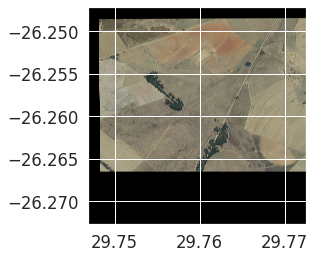

In [40]:
preview_tif(cropped_raster)

In [21]:
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5)

# Get data and set working directory
et.data.get_data(path_labels)
#os.chdir(os.path.join(et.io.HOME, 'earth-analytics','data'))

# 2. Open Raster and Vector Layers
lidar_chm_path = example_tif

lidar_chm_im = rxr.open_rasterio(example_tif,
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_im.plot.imshow()
ax.set(title="Example TIF")

ax.set_axis_off()
plt.show()

KeyError: "Key '/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/' not found in earthpy.io.DATA_URLS. Choose one of: 'california-rim-fire', 'co-flood-extras', 'cold-springs-fire', 'cold-springs-landsat-scenes', 'cold-springs-modis-h4', 'colorado-flood', 'cs-test-landsat', 'cs-test-naip', 'naip-fire-crop', 'ndvi-automation', 'spatial-vector-lidar', 'twitter-flood', 'vignette-elevation', 'vignette-landsat'"

In [ ]:
path_labels

In [ ]:
#inspect_tif(example_tif)

In [ ]:
lidar_chm_path = os.path.join("colorado-flood", 
                              "spatial"
                              "boulder-leehill-rd",
                              "outputs",
                              "lidar_chm.tif")

lidar_chm_im = rxr.open_rasterio(example_tif,
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_im.plot.imshow()
ax.set(title="Lidar Canopy Height Model (CHM)")

ax.set_axis_off()
plt.show()

In [ ]:
# Open crop extent (your study area extent boundary)
crop_extent = gpd.read_file(example_tif)

print('crop extent crs: ', crop_extent.crs)
print('lidar crs: ', lidar_chm_im.rio.crs)

In [ ]:
# Plot the crop boundary layer
# Note this is just an example so you can see what it looks like
# You don't need to plot this layer in your homework!
fig, ax = plt.subplots(figsize=(6, 6))

crop_extent.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_im.plot.imshow(ax=ax)

crop_extent.plot(ax=ax,
                 alpha=.8)
ax.set(title="Raster Layer with Shapefile Overlayed")

ax.set_axis_off()
plt.show()